In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import chain

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

ROOT_DIR = '../datasets/lung_segmentation/'
MY_DATA_DIR = '../mydatadir/lung_segmentation/'
IMG_DIR = os.path.join(ROOT_DIR, 'CXR_png')
MASK_DIR = os.path.join(ROOT_DIR, 'masks')

img_w = 128
img_h = 128

In [2]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model
    
    https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb
    """
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [3]:
X = np.load(os.path.join(MY_DATA_DIR, 'X_train.npy'))
y = np.load(os.path.join(MY_DATA_DIR, 'y_train.npy'))

print('Memory usage \n \
X: {0:.1f} MB, Y: {1:.1f} MB'.format(X.nbytes/1e6, y.nbytes/1e6))

Memory usage 
 X: 46.1 MB, Y: 46.1 MB


In [4]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
input_img = Input((img_h, img_w, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [7]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_lung_segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [8]:
results = model.fit(X_train, y_train, batch_size=32, epochs=15, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7139
Epoch 00001: val_loss improved from inf to 0.58117, saving model to model_lung_segmentation.h5
20/20 [==============================] - 50s 2s/step - loss: 0.4743 - accuracy: 0.7139 - val_loss: 0.5812 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.8742
Epoch 00002: val_loss improved from 0.58117 to 0.43409, saving model to model_lung_segmentation.h5
20/20 [==============================] - 47s 2s/step - loss: 0.2165 - accuracy: 0.8742 - val_loss: 0.4341 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.8779
Epoch 00003: val_loss improved from 0.43409 to 0.27837, saving model to model_lung_segmentation.h5
20/20 [==============================] - 49s 2s/step - loss: 0.1768 - accuracy: 0.8779 - val_loss: 0.2784 - val_accuracy: 0.8555 - lr: 0.0010

In [9]:
# load the best model
model.load_weights('model_lung_segmentation.h5')

In [10]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

3/3 [==============================] - 0s 137ms/step - loss: 0.1199 - accuracy: 0.8741


[0.11987491697072983, 0.87406986951828]

In [11]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

3/3 [==============================] - 0s 115ms/step


In [12]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

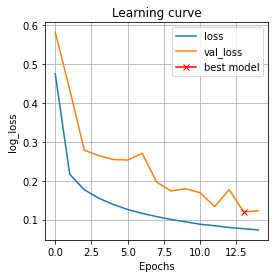

In [14]:
fig, ax = plt.subplots(1, figsize=(4, 4))

plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")

plt.plot(np.argmin(results.history["val_loss"]), 
            np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

ax.set_xlabel("Epochs")
ax.set_ylabel("log_loss")
ax.set_title("Learning curve")
ax.legend()

ax.grid()
plt.show()

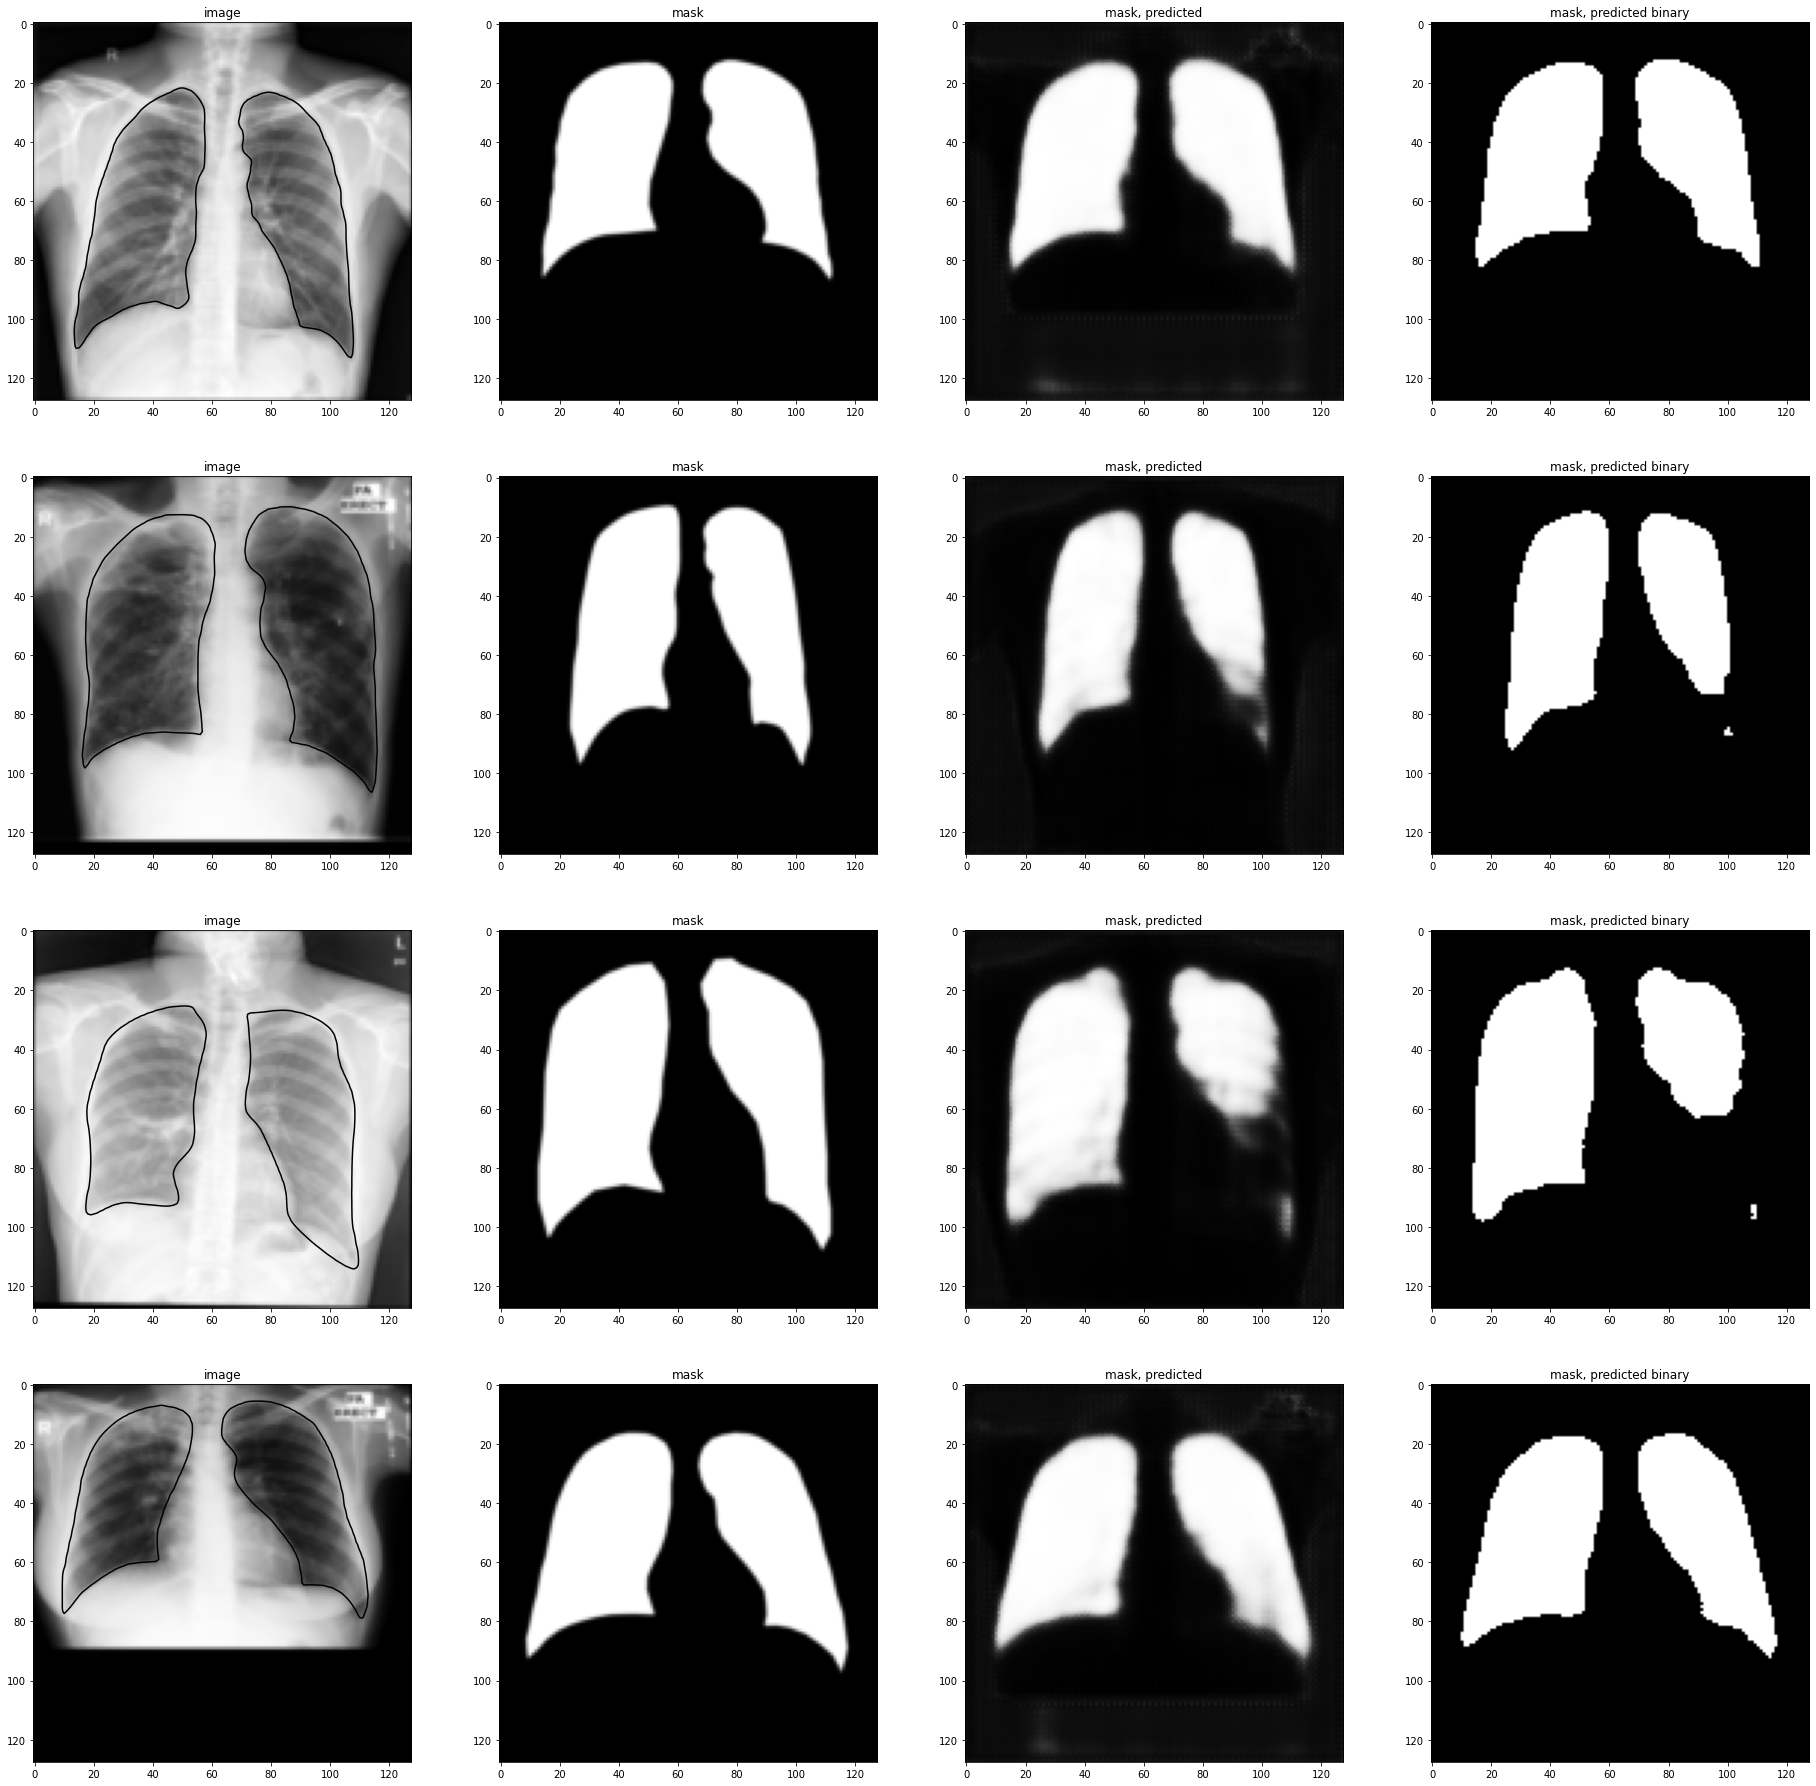

In [32]:
#rr = np.random.randint(0, len(X))
rr = 64

fig, ax = plt.subplots(4, 4, figsize=(32, 32))

for i in range(0, 4):
    
    rr = i + 16
    
    ax[i, 0].imshow(X[rr, :, :, 0], cmap='gray')
    ax[i, 0].contour(y[rr].squeeze(), colors='k', levels=[0.5])

    ax[i, 1].imshow(y_valid[rr, :, :, 0], cmap='gray')
    ax[i, 2].imshow(preds_val[rr, :, :, 0], cmap='gray')
    ax[i, 3].imshow(preds_val_t[rr, :, :, 0], cmap='gray')
    
    ax[i, 0].set_title('image')
    ax[i, 1].set_title('mask')
    ax[i, 2].set_title('mask, predicted')
    ax[i, 3].set_title('mask, predicted binary')

plt.show()